In [1]:
import EOSutils as meos

import numpy as np
import matplotlib.pyplot as plt

import matplotlib.style
import matplotlib as mpl
import matplotlib.colors as colors
import matplotlib.cm as cmx
from mpl_toolkits.axes_grid1 import make_axes_locatable

mpl.style.use('classic')

from astropy.table import Table
from astropy import units as u
from astropy.constants import G

import mesa_helper as mh
import os
import shutil
import copy

from scipy import interpolate, optimize
from scipy.linalg import lstsq as scipy_lstsq
from scipy.ndimage import gaussian_filter
import scipy.integrate as integrate
import decimal 

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

# calculating Hugoniot from EoS tables

In [3]:
# strategy:
# calculate H = (u1 - u0) + (1/2)*(p1 + p0)*((1/rho1 - 1/rho0)) at every point in the table for a given set of ICs
# identify sign changes; interpolate between them to find the precise (rho,T,P,u) that yield H=0
# plot these points

# H ICs
'''
H_rho0 = 0.0855 #g/cm3
H_T0 = 20 #K
H_U0 = 0 #-314 * 1.e7 #kJ/g, converted to erg/g
H_P0 = 0 #negligible # alternatively? 3.e9 #from Yamila's notes
'''
R = 8.314e7 #erg/(K*mol)
kB = 1.3806e-16 #erg/K
amu = 1.6605e-24 #g

H_rho0 = 0.0855 #g/cm3
H_T0 = 20 #K
H_U0 = (5/2.)*(R/(2*1.008))*H_T0
H_P0 = (kB/(2*1.008*amu))*H_rho0*H_T0

# He ICs
'''
He_rho0 = 0.1235 #g/cm3
He_T0 = 4 #K
He_U0 = 20 * 1.e7 # J/g, converted to erg/g ## Note different units from H
He_P0 = 1 * 1.e6 # bar, converted to erg/cm3
'''
He_rho0 = 0.1235 #g/cm3
He_T0 = 4 #K
He_U0 = (3/2.)*(R/(4.0026))*He_T0
He_P0 = (kB/(4.0026*amu))*He_rho0*He_T0


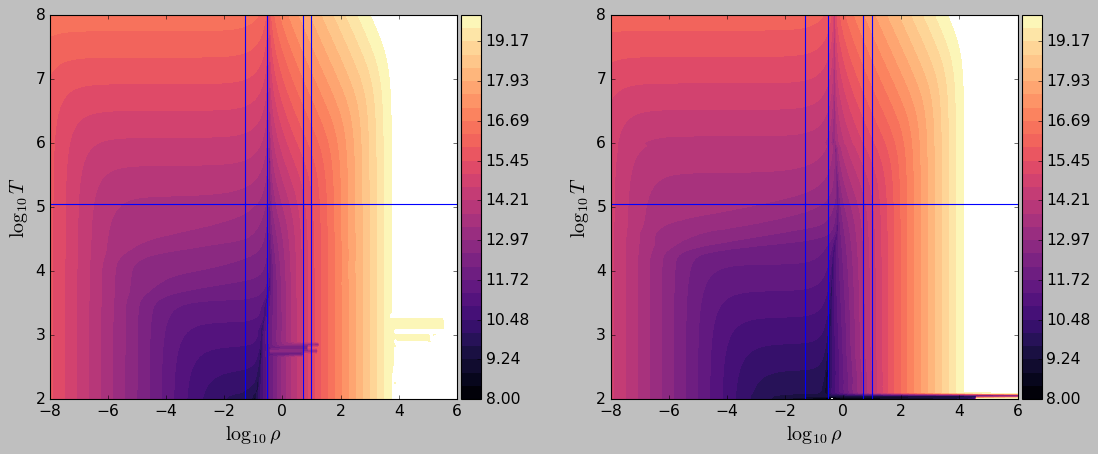

In [4]:

cms19_H = meos.CMStable("../../2021_chabrier+_tables/TABLE_H_Trho_v1",units='cgs',F_smoothing_kernel=5)
cms19_He = meos.CMStable("../../2021_chabrier+_tables/TABLE_HE_Trho_v1",units='cgs',F_smoothing_kernel=5)
gridvar = 'rho'
H_savefilestring='CMS19_H_Trho'
He_savefilestring='CMS19_He_Trho'
'''
cms19_H = meos.CMStable("../../2021_chabrier+_tables/TABLE_H_TP_v1",units='cgs',F_smoothing_kernel=5)
cms19_He = meos.CMStable("../../2021_chabrier+_tables/TABLE_HE_TP_v1",units='cgs',F_smoothing_kernel=5)
gridvar = 'P'
H_savefilestring='CMS19_H_TP'
He_savefilestring='CMS19_He_TP'

cms19_H = meos.SCVHtable("../../1995_SCVH/h_tab_i.dat",units='cgs',F_smoothing_kernel=5)
cms19_He = meos.SCVHtable("../../1995_SCVH/he_tab_i.dat",units='cgs',F_smoothing_kernel=5)
gridvar = 'P'
H_savefilestring='SCVH_H_TP'
He_savefilestring='SCVH_He_TP'
'''
H_naive_hugo = np.abs((10**cms19_H.log10Egrid - H_U0) + 0.5*(10**cms19_H.log10Pgrid+H_P0)*((1/10**cms19_H.log10rhogrid) - (1/H_rho0)))
He_naive_hugo = np.abs((10**cms19_He.log10Egrid - He_U0) + 0.5*(10**cms19_He.log10Pgrid+He_P0)*((1/10**cms19_He.log10rhogrid) - (1/He_rho0)))

if gridvar == 'rho':
    meos.contourf_sublots_with_colorbars(nRow=1, nCol=2, 
                                    xs=cms19_H.log10rhogrid,
                                    ys=cms19_H.log10Tgrid,
                                    zs=[np.log10(H_naive_hugo),np.log10(He_naive_hugo)],
                                    xlims=(-8,6),
                                    ylims=(2,8),
                                    zlims=(8,20),
                                    levels=30,
                                    xlabels=r'$\log_{10}\rho$',
                                    ylabels=r'$\log_{10}T$',
                                    zlabels='',
                                    cmap='magma', vlines=None, hlines=None, otherlines_x=None, otherlines_y=None, savename=None)
elif gridvar == 'P':
    meos.contourf_sublots_with_colorbars(nRow=1, nCol=2, 
                                        xs=cms19_H.log10Pgrid,
                                        ys=cms19_H.log10Tgrid,
                                        zs=[np.log10(H_naive_hugo),np.log10(He_naive_hugo)],
                                        xlims=(1,23),
                                        ylims=(2,8),
                                        zlims=(8,20),
                                        levels=30,
                                        xlabels=r'$\log_{10}P$',
                                        ylabels=r'$\log_{10}T$',
                                        zlabels='',
                                        cmap='magma', vlines=None, hlines=None, otherlines_x=None, otherlines_y=None, savename=None)


# rho, T free search

In [5]:
def calc_hugoniot_rhoTgrid(EOStable, U0, rho0, P0):
    
    log10T = EOStable.independent_arr_1
    log10rho = EOStable.independent_arr_2
    
    interp_log10P = interpolate.RegularGridInterpolator(points=(log10rho, log10T), values=EOStable.log10Pgrid, bounds_error=False, fill_value=None, method='linear')
    interp_log10E = interpolate.RegularGridInterpolator(points=(log10rho, log10T), values=EOStable.log10Egrid, bounds_error=False, fill_value=None, method='linear')

    def calc_H(params):
        rho = params[0]
        T = params[1]
        
        U = interp_log10E((rho, T))
        
        P = interp_log10P((rho, T))
        return np.abs((10**U - U0) + 0.5*(10**P+P0)*((1/10**rho) - (1/rho0)))

    ni, nj = np.shape(EOStable.log10rhogrid)

    hugoniot_log10rho = []
    hugoniot_log10T = []
    hugoniot_eta = []
    hugoniot_P_GPa = []

    #for i in range(ni):
    for i in np.arange(120,190,5):
        log10rho_i = EOStable.independent_arr_2[i]
        #for j in range(nj):
        for j in np.arange(0,nj,5):
            log10T_j = EOStable.independent_arr_1[j]

            #print(log10rho_i,log10T_j)

            x0 = [log10rho_i, log10T_j]

            res = optimize.minimize(calc_H, x0, method='Nelder-Mead', tol=1.e-8)

            res_rho = res.x[0]
            res_P = interp_log10P((res.x[0], res.x[1]))

            hugoniot_eta.append(10**res_rho/rho0)
            hugoniot_P = 10**res_P 
            hugoniot_P_GPa.append(hugoniot_P*1.e-10)

            hugoniot_log10rho.append(res.x[0])
            hugoniot_log10T.append(res.x[1])

    return np.array(hugoniot_eta), np.array(hugoniot_P_GPa), np.array(hugoniot_log10rho), np.array(hugoniot_log10T)

In [6]:
def calc_hugoniot_PTgrid(EOStable, U0, rho0, P0):
    
    log10T = EOStable.independent_arr_1
    log10P = EOStable.independent_arr_2
    
    interp_log10rho = interpolate.RegularGridInterpolator(points=(log10P, log10T), values=EOStable.log10rhogrid, bounds_error=False, fill_value=None, method='linear')
    interp_log10E = interpolate.RegularGridInterpolator(points=(log10P, log10T), values=EOStable.log10Egrid, bounds_error=False, fill_value=None, method='linear')

    def calc_H(params):
        P = params[0]
        T = params[1]
        
        U = interp_log10E((P, T))
        
        rho = interp_log10rho((P, T))
        return np.abs((10**U - U0) + 0.5*(10**P+P0)*((1/10**rho) - (1/rho0)))

    ni, nj = np.shape(EOStable.log10Pgrid)

    hugoniot_log10P = []
    hugoniot_log10T = []
    hugoniot_log10rho = []
    hugoniot_eta = []
    hugoniot_P_GPa = []

    for i in range(ni):
        log10P_i = EOStable.independent_arr_2[i]
        for j in range(nj):
            log10T_j = EOStable.independent_arr_1[j]


            x0 = [log10P_i, log10T_j]

            res = optimize.minimize(calc_H, x0, method='Nelder-Mead', tol=1.e-8)

            res_P = res.x[0]
            res_rho = interp_log10rho((res.x[0], res.x[1]))

            hugoniot_eta.append(10**res_rho/rho0)
            hugoniot_P = 10**res_P 
            hugoniot_P_GPa.append(hugoniot_P*1.e-10)

            hugoniot_log10P.append(res.x[0])
            hugoniot_log10T.append(res.x[1])
            hugoniot_log10rho.append(res_rho)

    return np.array(hugoniot_eta), np.array(hugoniot_P_GPa), np.array(hugoniot_log10P), np.array(hugoniot_log10T), np.array(hugoniot_log10rho)

# search with T fixed 

In [7]:
def calc_hugoniot_rhogrid(EOStable, U0, rho0, P0):
    
    log10T = EOStable.independent_arr_1
    log10rho = EOStable.independent_arr_2
    
    interp_log10P = interpolate.RegularGridInterpolator(points=(log10rho, log10T), values=EOStable.log10Pgrid, bounds_error=False, fill_value=None, method='linear')
    interp_log10E = interpolate.RegularGridInterpolator(points=(log10rho, log10T), values=EOStable.log10Egrid, bounds_error=False, fill_value=None, method='linear')

    def calc_H(rho, T):
        U = interp_log10E((rho, T))
        
        P = interp_log10P((rho, T))
        return np.abs((10**U - U0) + 0.5*(10**P+P0)*((1/10**rho) - (1/rho0)))

    ni, nj = np.shape(EOStable.log10rhogrid)

    hugoniot_log10rho = []
    hugoniot_log10T = []
    hugoniot_eta = []
    hugoniot_P_GPa = []

    for i in np.arange(0,ni,5):
    #for i in range(ni):
        log10rho_i = EOStable.independent_arr_2[i]
        for j in range(nj):
            log10T_j = EOStable.independent_arr_1[j]
            res = optimize.minimize(calc_H, x0=log10rho_i, args=(log10T_j), method='Nelder-Mead',tol=1.e-8)
    
            res_rho = res.x[0]
            res_P = interp_log10P((res.x[0], log10T_j))
    
            hugoniot_eta.append(10**res_rho/rho0)
            hugoniot_P = 10**res_P 
            hugoniot_P_GPa.append(hugoniot_P*1.e-10)
    
            hugoniot_log10rho.append(res.x[0])
            hugoniot_log10T.append(log10T_j)

    return np.array(hugoniot_eta), np.array(hugoniot_P_GPa), np.array(hugoniot_log10rho), np.array(hugoniot_log10T)

In [8]:
def calc_hugoniot_Pgrid(EOStable, U0, rho0, P0):
    
    log10T = EOStable.independent_arr_1
    log10P = EOStable.independent_arr_2
    
    interp_log10rho = interpolate.RegularGridInterpolator(points=(log10P, log10T), values=EOStable.log10rhogrid, bounds_error=False, fill_value=None, method='linear')
    interp_log10E = interpolate.RegularGridInterpolator(points=(log10P, log10T), values=EOStable.log10Egrid, bounds_error=False, fill_value=None, method='linear')

    def calc_H(P, T):
        
        U = interp_log10E((P, T))
        
        rho = interp_log10rho((P, T))
        return np.abs((10**U - U0) + 0.5*(10**P+P0)*((1/10**rho) - (1/rho0)))

    ni, nj = np.shape(EOStable.log10Pgrid)

    hugoniot_log10P = []
    hugoniot_log10T = []
    hugoniot_log10rho = []
    hugoniot_eta = []
    hugoniot_P_GPa = []

    for i in range(ni):
    #for i in np.arange(0,ni,5):
        log10P_i = EOStable.independent_arr_2[i]
        for j in range(nj):
        #for j in np.arange(0,nj,5):
            log10T_j = EOStable.independent_arr_1[j]
            res = optimize.minimize(calc_H, x0=log10P_i, args=(log10T_j), method='Nelder-Mead', tol=1.e-8)

            res_P = res.x[0]
            res_rho = interp_log10rho((res.x[0], log10T_j))

            hugoniot_eta.append(10**res_rho/rho0)
            hugoniot_P = 10**res_P 
            hugoniot_P_GPa.append(hugoniot_P*1.e-10)

            hugoniot_log10P.append(res.x[0])
            hugoniot_log10T.append(log10T_j)
            hugoniot_log10rho.append(res_rho)

    return np.array(hugoniot_eta), np.array(hugoniot_P_GPa), np.array(hugoniot_log10P), np.array(hugoniot_log10T), np.array(hugoniot_log10rho)

# run search

In [9]:
if gridvar == 'rho':
    #H_eta, H_P, H_log10rho, H_log10T = calc_hugoniot_rhoTgrid(EOStable=cms19_H, U0=H_U0, rho0=H_rho0, P0=H_P0)
    #He_eta, He_P, He_log10rho, He_log10T = calc_hugoniot_rhoTgrid(EOStable=cms19_He, U0=He_U0, rho0=He_rho0, P0=He_P0)

    H_eta, H_P, H_log10rho, H_log10T = calc_hugoniot_rhogrid(EOStable=cms19_H, U0=H_U0, rho0=H_rho0, P0=H_P0)
    He_eta, He_P, He_log10rho, He_log10T = calc_hugoniot_rhogrid(EOStable=cms19_He, U0=He_U0, rho0=He_rho0, P0=He_P0)

if gridvar == 'P':
    #H_eta, H_P, H_log10P, H_log10T = calc_hugoniot_PTgrid(EOStable=cms19_H, U0=H_U0, rho0=H_rho0, P0=H_P0)
    #He_eta, He_P, He_log10P, He_log10T = calc_hugoniot_PTgrid(EOStable=cms19_He, U0=He_U0, rho0=He_rho0, P0=He_P0)

    H_eta, H_P, H_log10P, H_log10T, H_log10rho =      calc_hugoniot_Pgrid(EOStable=cms19_H, U0=H_U0, rho0=H_rho0, P0=H_P0)
    
    He_eta, He_P, He_log10P, He_log10T, He_log10rho = calc_hugoniot_Pgrid(EOStable=cms19_He, U0=He_U0, rho0=He_rho0, P0=He_P0)

    H_remove_P_extremes_mask = (H_log10P >= 7) & (H_log10P <= 17)
    H_eta = H_eta[H_remove_P_extremes_mask]
    H_P = H_P[H_remove_P_extremes_mask]
    H_log10P = H_log10P[H_remove_P_extremes_mask]
    H_log10T = H_log10T[H_remove_P_extremes_mask]
    H_log10rho = H_log10rho[H_remove_P_extremes_mask]

    He_remove_P_extremes_mask = (He_log10P >= 7) & (He_log10P <= 17)
    He_eta = He_eta[He_remove_P_extremes_mask]
    He_P = He_P[He_remove_P_extremes_mask]
    He_log10P = He_log10P[He_remove_P_extremes_mask]
    He_log10T = He_log10T[He_remove_P_extremes_mask]
    He_log10rho = He_log10rho[He_remove_P_extremes_mask]

H_boundary = 3.3 + 0.5*H_log10rho + np.log10(cms19_H.atomic_number) - (5./3)*np.log10(cms19_H.mass_number)
He_boundary = 3.3 + 0.5*He_log10rho + np.log10(cms19_He.atomic_number) - (5./3)*np.log10(cms19_He.mass_number)

H_finitemask = np.isfinite(H_eta) & np.isfinite(H_P) #& (H_log10T>= H_boundary) & (H_log10rho >= -8.)
He_finitemask = np.isfinite(He_eta) & np.isfinite(He_P) #& (He_log10T>= He_boundary) & (He_log10rho >= -8.)


# plot results of search

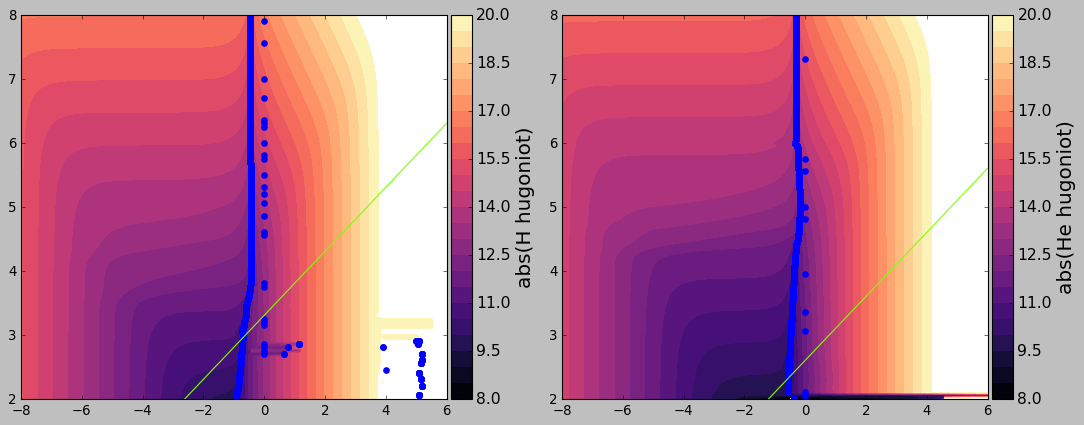

In [10]:
if gridvar=='rho':
    fig, axes = plt.subplots(1,2,figsize=(16,6))
    
    divider0 = make_axes_locatable(axes[0])
    cax0 = divider0.append_axes('right', size='5%', pad=0.05)
    
    cs0 = axes[0].contourf(cms19_H.log10rhogrid, cms19_H.log10Tgrid, np.log10(H_naive_hugo), shading='nearest', cmap='magma', levels=np.linspace(8,20,25))
    axes[0].plot(H_log10rho[H_finitemask], H_log10T[H_finitemask], 'bo', linestyle='None',mec='None')

    cb0 = fig.colorbar(cs0, cax=cax0, orientation='vertical')
    cb0.set_label('abs(H hugoniot)', size=18)
    cb0.ax.tick_params(labelsize=14)

    divider1 = make_axes_locatable(axes[1])
    cax1 = divider1.append_axes('right', size='5%', pad=0.05)
    
    cs1 = axes[1].contourf(cms19_He.log10rhogrid, cms19_He.log10Tgrid, np.log10(He_naive_hugo), shading='nearest', cmap='magma', levels=np.linspace(8,20,25))
    axes[1].plot(He_log10rho[He_finitemask], He_log10T[He_finitemask], 'bo', linestyle='None',mec='None')
    
    cb1 = fig.colorbar(cs1, cax=cax1, orientation='vertical')
    cb1.set_label('abs(He hugoniot)', size=18)
    cb1.ax.tick_params(labelsize=14)

    log10rho_ = np.linspace(-8,8,100)
    axes[0].plot(log10rho_, 3.3 + (1./2.)*log10rho_ + np.log10(cms19_H.atomic_number) - (5./3)*np.log10(cms19_H.mass_number), ls='-', color='#7FFF00')
    axes[1].plot(log10rho_, 3.3 + (1./2.)*log10rho_ + np.log10(cms19_He.atomic_number) - (5./3)*np.log10(cms19_He.mass_number), ls='-', color='#7FFF00')
       
    for ax in axes:       
        ax.set_xlim(-8,6)
        ax.set_ylim(2,8)
    plt.show()

elif gridvar=='P':
    fig, axes = plt.subplots(1,2,figsize=(16,6))
    
    divider0 = make_axes_locatable(axes[0])
    cax0 = divider0.append_axes('right', size='5%', pad=0.05)
    
    cs0 = axes[0].contourf(cms19_H.log10Pgrid, cms19_H.log10Tgrid, np.log10(H_naive_hugo), shading='nearest', cmap='magma', levels=np.linspace(8,20,25))
    axes[0].plot(H_log10P[H_finitemask], H_log10T[H_finitemask], 'bo', linestyle='None',mec='None')

    #CMS19 TP
    #H_exclude_mask = ((H_log10T[H_finitemask] < 3) & (H_log10P[H_finitemask] < 11.5)) | ((H_log10T[H_finitemask] < 3) & (H_log10P[H_finitemask] > 12))
    #axes[0].plot(H_log10P[H_finitemask][H_exclude_mask], H_log10T[H_finitemask][H_exclude_mask], marker='o', color='#7FFF00',linestyle='None',mec='None')
    #axes[0].plot(H_log10P[H_finitemask][~H_exclude_mask], H_log10T[H_finitemask][~H_exclude_mask], marker='o', color='r',linestyle='None',mec='None')
    
    cb0 = fig.colorbar(cs0, cax=cax0, orientation='vertical')
    cb0.set_label('abs(H hugoniot)', size=18)
    cb0.ax.tick_params(labelsize=14)

    divider1 = make_axes_locatable(axes[1])
    cax1 = divider1.append_axes('right', size='5%', pad=0.05)
    
    cs1 = axes[1].contourf(cms19_He.log10Pgrid, cms19_He.log10Tgrid, np.log10(He_naive_hugo), shading='nearest', cmap='magma', levels=np.linspace(8,20,25))
    axes[1].plot(He_log10P[He_finitemask], He_log10T[He_finitemask], 'bo', linestyle='None',mec='None')

    #CMS19 TP
    #He_exclude_mask = ((He_log10T[He_finitemask] < 3) & (He_log10P[He_finitemask] < 9)) 
    #axes[1].plot(He_log10P[He_finitemask][He_exclude_mask], He_log10T[He_finitemask][He_exclude_mask], marker='o', color='#7FFF00',linestyle='None',mec='None')
    #axes[1].plot(He_log10P[~He_exclude_mask], He_log10T[~He_exclude_mask], 'ro', linestyle='None',mec='None')

    cb1 = fig.colorbar(cs1, cax=cax1, orientation='vertical')
    cb1.set_label('abs(He hugoniot)', size=18)
    cb1.ax.tick_params(labelsize=14)
    
    for ax in axes:       
        ax.set_xlim(1,23)
        #ax.set_xlim(5,12)
        ax.set_ylim(2,8)
    plt.show()

# save results

In [12]:
H_to_save = np.vstack((H_eta[H_finitemask],H_P[H_finitemask])).T
He_to_save = np.vstack((He_eta[He_finitemask],He_P[He_finitemask])).T

print(np.shape(H_to_save))
print(np.shape(He_to_save))


(6897, 2)
(6897, 2)


In [13]:
H_fname = "./eos_hugoniot_{0}.txt".format(H_savefilestring)
He_fname = "./eos_hugoniot_{0}.txt".format(He_savefilestring)

np.savetxt(H_fname, H_to_save, header='eta[dimensionless] P[GPa]')
np.savetxt(He_fname, He_to_save, header='eta[dimensionless] P[GPa]')